(301, 35)
(301, 35)
|   iter    |  target   |  dropout  | l1_lambda | l2_lambda | learni... |
-------------------------------------------------------------------------
| 1         | -0.1609   | 0.2502    | 0.7203    | 0.0001144 | 0.003093  |
| 2         | 0.5102    | 0.08805   | 0.09234   | 0.1863    | 0.003521  |
| 3         | -0.1609   | 0.2381    | 0.5388    | 0.4192    | 0.006884  |
| 4         | -0.1609   | 0.1227    | 0.8781    | 0.02739   | 0.006738  |
| 5         | -0.1609   | 0.2504    | 0.5587    | 0.1404    | 0.002061  |
| 6         | -0.1608   | 0.4804    | 0.9683    | 0.3134    | 0.006954  |
| 7         | -0.1609   | 0.5258    | 0.8946    | 0.08504   | 0.0004866 |
| 8         | -0.1609   | 0.1019    | 0.8781    | 0.09835   | 0.004269  |
| 9         | -0.1608   | 0.5747    | 0.5332    | 0.6919    | 0.003224  |
| 10        | -0.1609   | 0.4119    | 0.8346    | 0.01829   | 0.007526  |
| 11        | 0.7057    | 0.0       | 0.0       | 0.0       | 0.01      |
| 12        | 0.69

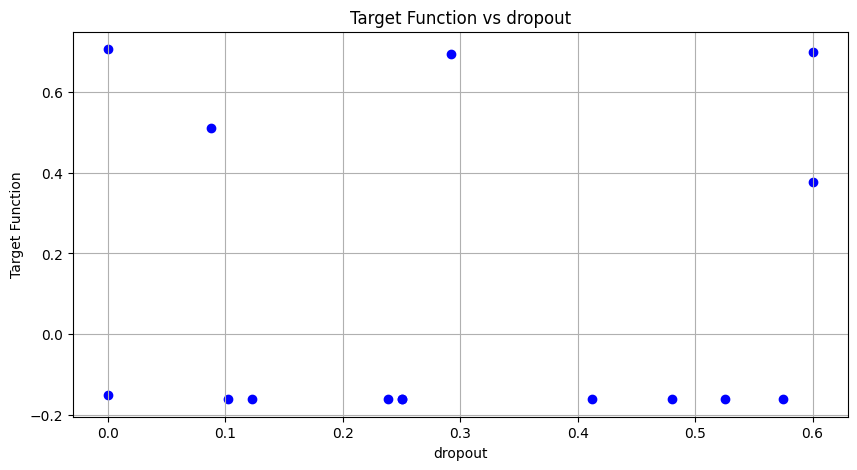

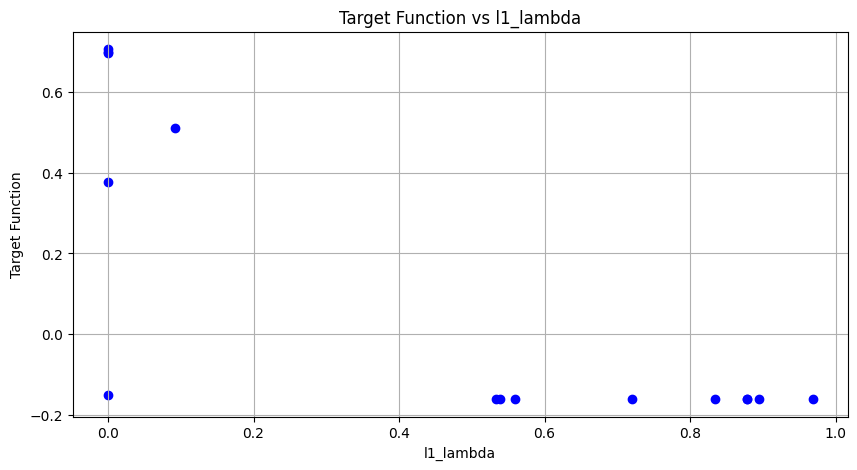

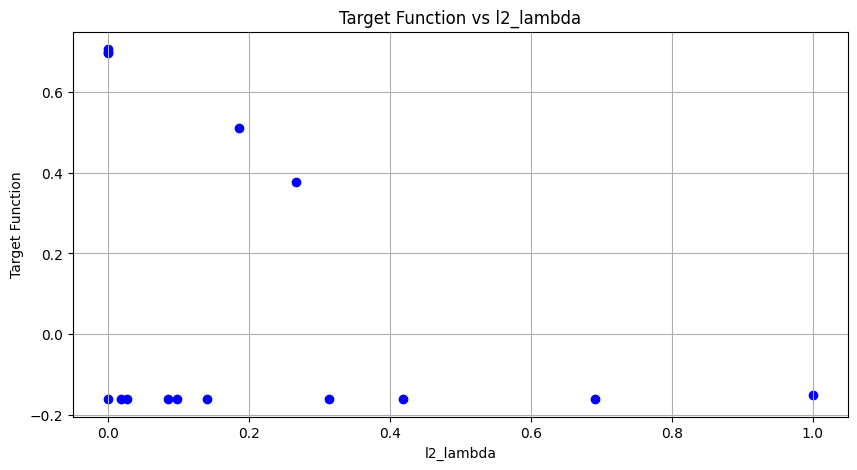

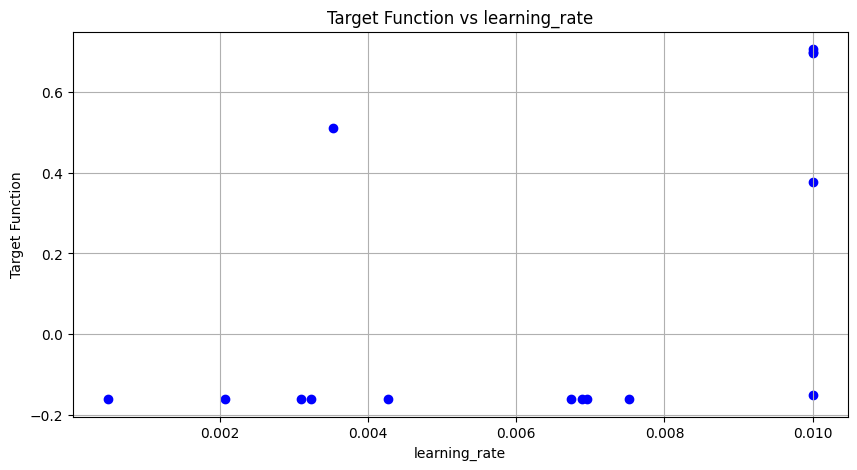

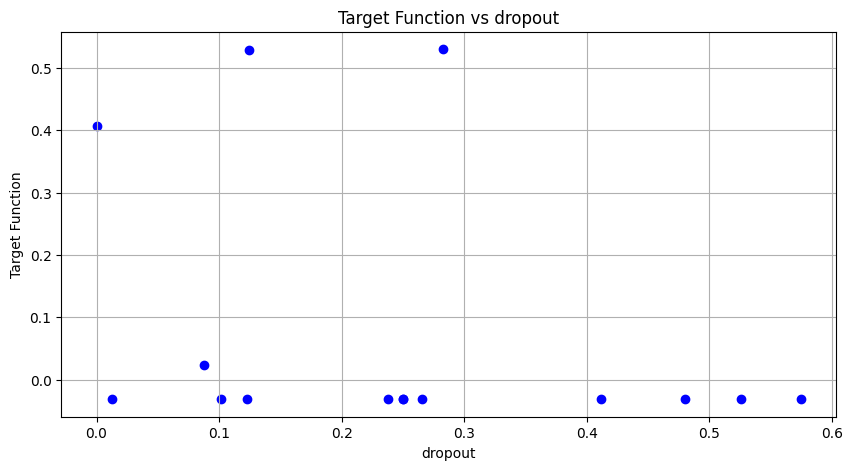

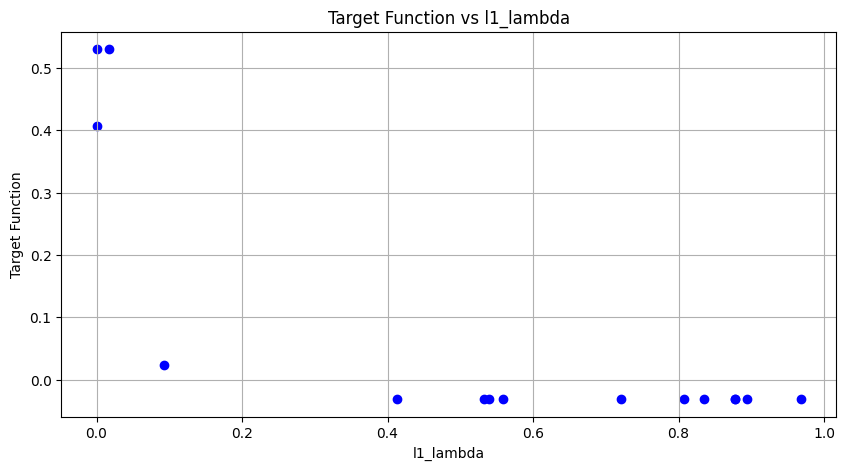

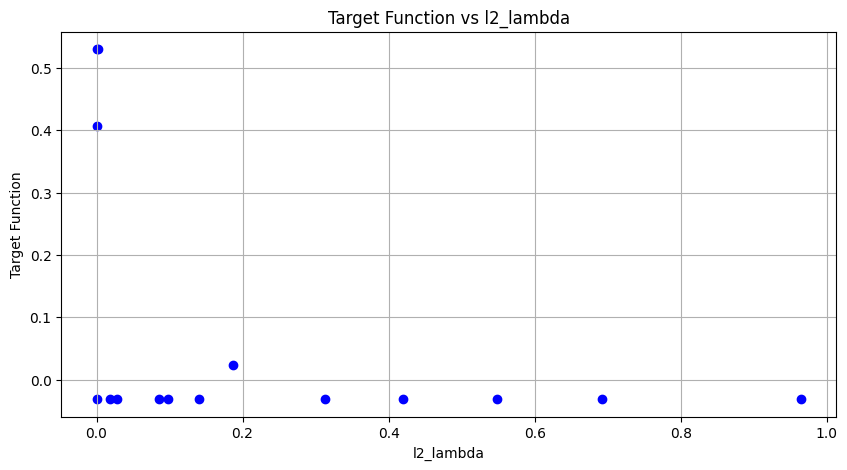

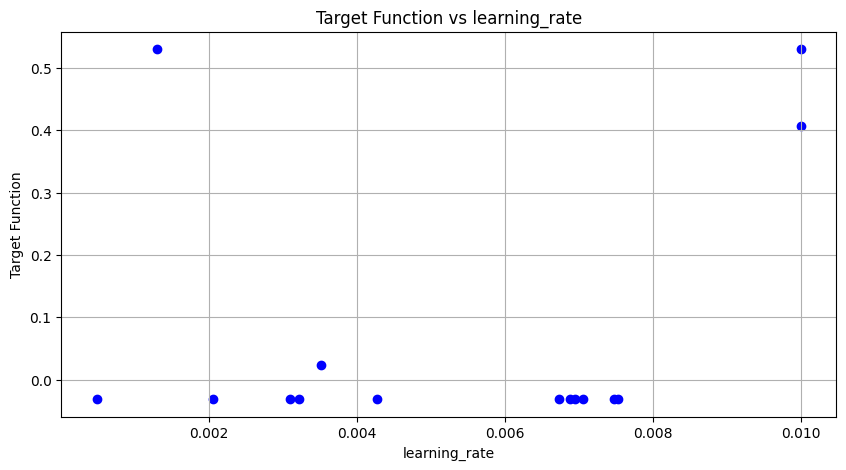

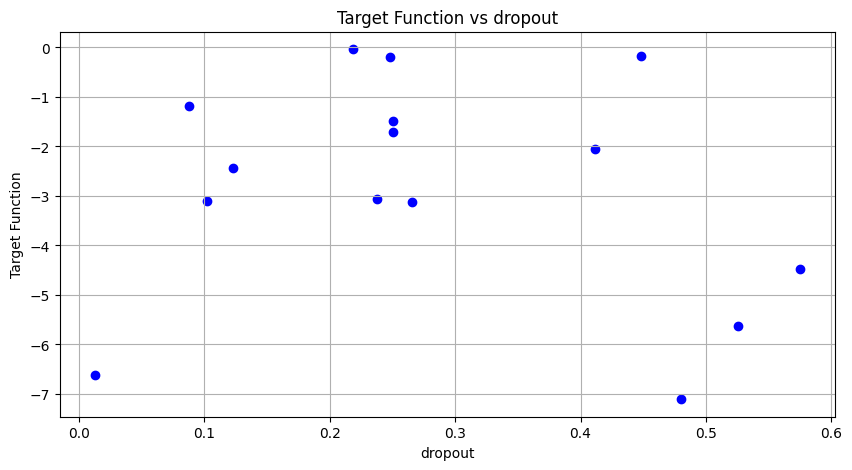

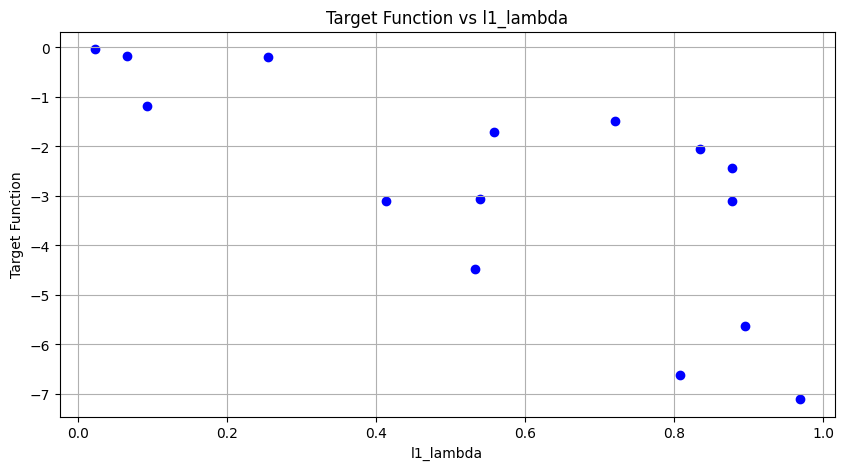

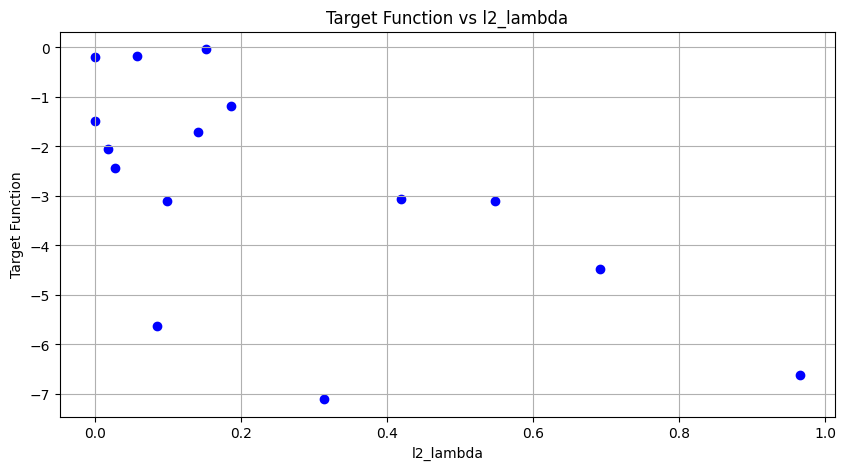

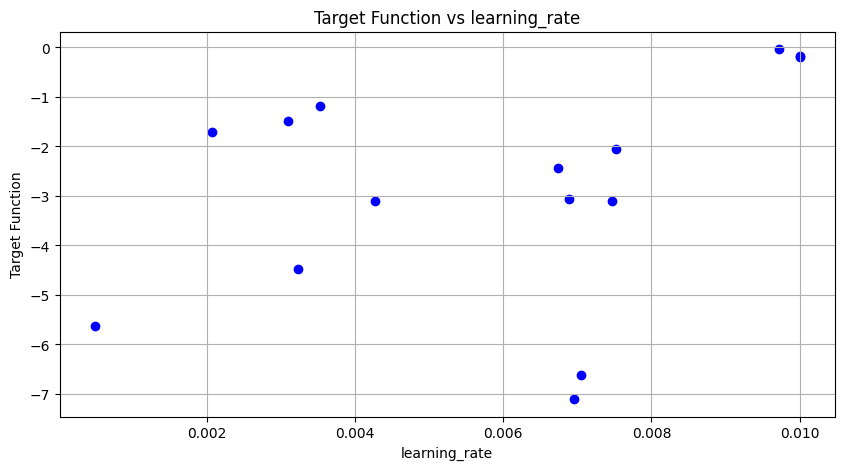

In [1]:
from scipy.stats import zscore
import pandas as pd
import logging
import os
logging.disable(logging.WARNING)
import torch
import time


from Pytorch_ANN import *
from bayes_opt import BayesianOptimization
import time
from sklearn.model_selection import KFold

'''loading the data'''
all_labels = ['height', 'phi', 'theta', 
        'impact site x', 'impact site y', 'impact site z', 
        'impact site r', 'impact site phi', 'impact site theta']

# Generate some synthetic data for demonstration purposes
full_dataset_pathname = "/Volumes/Jake_ssd/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
# full_dataset_pathname = "/Volumes/Jake_ssd/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
df = pd.read_csv(full_dataset_pathname)



labels_to_predict = ['impact site x', 'impact site y', 'height']

for label in labels_to_predict:

    if(df.columns.__contains__('timestep_init')):
        df = df.drop('timestep_init', axis=1)
    if(df.columns.__contains__('Unnamed: 0')):
        df = df.drop('Unnamed: 0', axis=1)

    feature_df = df.drop(all_labels, axis=1)
    label_df = df[label]



    '''preprocessing the data'''
    # First, zero-center the features by subtracting the mean
    feature_df_centered = feature_df - feature_df.mean()

    # Then, normalize the data to be between -10 and 10 by dividing by the half-range and multiplying by 10
    feature_df_range = (feature_df.max() - feature_df.min()) / 2
    feature_df_normalized = (feature_df_centered / feature_df_range) * 10
    feature_df = feature_df_normalized

    train_feats_df, test_feats_df, train_label_df, test_label_df = train_test_split(
        feature_df, 
        label_df, 
        test_size=0.2,
        random_state=2  # For reproducibility
    )


    x = feature_df.values
    y = label_df.values

    '''Convert data to PyTorch tensors'''
    x_tensor = torch.FloatTensor(x).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    device = 'cpu'

    saving_folder = f'/Volumes/Jake_ssd/bayesian_optimization/{label}/ANN'
    if(not os.path.exists(saving_folder)): os.makedirs(saving_folder)

    optimizer = do_bayesian_optimization(x_tensor, y_tensor, num_iter=5)
    plot_parameter_trials(optimizer, saving_folder)


In [2]:
# # Evaluation function
# SPLITS = 5
# EPOCHS = 100
# PATIENCE = 50

# def evaluate_network(learning_rate=1e-3, 
#                      batch_size = 100, 
#                      epochs=1000, 
#                      l1_lambda=0.001, 
#                      l2_lambda=0.001, 
#                      patience=200, 
#                      dropout=0.0, loss_func='MAE'):
    
#     kf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)
#     splits = [(train_index, test_index) for train_index, test_index in kf.split(x)]

    
#     # boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.2)
#     mean_benchmark = []
#     epochs_needed = []


#     for train, test in splits: 
#         '''splitting data into training and test tensors'''
#         X_train_tensor = x_tensor[train]
#         y_train_tensor = y_tensor[train]
#         X_test_tensor = x_tensor[test]
#         y_test_tensor = y_tensor[test]
        
#         model = ANNModel(input_size=x.shape[1], 
#                  output_size = 1, 
#                  dropout_rate = dropout).to(device)
        
#         if loss_func == "MAE":
#             criterion = nn.L1Loss()
#         elif loss_func == "MSE":
#             criterion = nn.MSELoss()
            
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

#         # dataset_train = TensorDataset(x_train, y_train)
#         # loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

#         best_loss = float('inf')
#         patience_counter = 0

#         '''further splitting training tensors into training and validation tensors'''
#         # Upper limit to train/val split indicies
#         upper_limit = y_train_tensor.__len__()
#         # Generate the two lists
#         train_indexes = random.sample(range(upper_limit), int(upper_limit * 0.8))
#         val_indexes = list(set(range(upper_limit)) - set(train_indexes))
#         x_train = X_train_tensor[train_indexes]
#         y_train = y_train_tensor[train_indexes]
#         x_val = X_train_tensor[val_indexes]
#         y_val = y_train_tensor[val_indexes]
        
#         '''putting training dataset into loader (preps the batches)'''
#         dataset_train = TensorDataset(x_train, y_train)
#         loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        
#         epochs_needed = []


#         best_val_loss = float('inf')
#         best_model = None
#         epochs_no_improve = 0
#         patience_counter = 0
#         best_loss = float('inf')

#         train_losses = []
#         val_losses = []
#         for epoch in range(epochs):
#             model.train()
#             total_loss = 0
#             batches = 0
#             for batch_x, batch_y in loader_train:
#                 optimizer.zero_grad()
#                 outputs = model(batch_x)
#                 loss = criterion(outputs.flatten(), batch_y)

#                 # Calculate L1 penalty (L1 regularization)
#                 l1_penalty = torch.tensor(0.).to(batch_x.device)
#                 for param in model.parameters():
#                     l1_penalty += torch.norm(param, 1)
#                 loss += l1_lambda * l1_penalty

#                 loss.backward()
#                 optimizer.step()
#                 total_loss += loss.item()
#                 batches += 1
#             train_losses.append(total_loss / batches) 

#             model.eval()
#             with torch.no_grad():
#                 outputs_validation = model(x_val)
#                 val_loss = criterion(outputs_validation.flatten(), y_val).item()
#                 val_losses.append(val_loss)
#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 best_model = model.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

#             if patience_counter >= patience:
#                 epochs_needed.append(epoch)
#                 # print('patience reached')
#                 break
#             # print(f'epoch = {epoch}, train loss = {train_losses[-1]}, val loss = {val_losses[-1]}')
        
#             # Evaluate
#         with torch.no_grad():
#             model.eval()
#             # Move predictions to CPU for evaluation
#             pred = model(x_val).cpu().numpy()
#             y_compare = y_val.cpu().numpy()
#             val_score = metrics.r2_score(y_compare, pred)
#             train_pred = model(x_train).cpu().numpy() 
#             y_compare_train = y_train.cpu().numpy()
#             train_score = metrics.r2_score(y_compare_train, train_pred)
#             # print(f'End train R2 score = {train_score} validation R2 score = {val_score}')
        
#         '''Load and return the best model (model with best validation score)'''
#         model.load_state_dict(best_model)
#             # Evaluate
#         with torch.no_grad():
#             model.eval()
#             # Move predictions to CPU for evaluation
#             pred = model(X_test_tensor).cpu().numpy() 
#             y_compare = y_test_tensor.cpu().numpy()
#             score = metrics.r2_score(y_compare, pred)
#             mean_benchmark.append(score)


#     return statistics.mean(mean_benchmark)
    
    
# evaluate_network(x_tensor, y_tensor, SPLITS, EPOCHS, PATIENCE, learning_rate=1e-3, batch_size = 10, dropout=0.0, loss_func='MAE')

# print('average test R2 across all folds in 5fold cv:')
# print(evaluate_network(learning_rate=1e-3,
#                        dropout=0.0))

average test R2 across all folds in 5fold cv:
0.4520741796011001


In [3]:
# '''this code should take about 2 min per 10 iterations with a batch size of 100 and epochs = 1000'''
# # Supress NaN warnings
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# '''Bounded region of parameter space'''
# pbounds = {
#         'learning_rate': (0.0001, 0.01),
#         'dropout': (0.0, 0.6), 
#         'l1_lambda': (0.0, 1.0),
#         'l2_lambda': (0.0, 1.0)
#         }

# '''define optimizer'''
# optimizer = BayesianOptimization(
#     f=evaluate_network,
#     pbounds=pbounds,
#     verbose=2,  # verbose = 1 prints only when a maximum
#     # is observed, verbose = 0 is silent
#     random_state=1,
#     allow_duplicate_points=True
# )

# '''start optimization'''
# start_time = time.time()
# optimizer.maximize(init_points=10, n_iter=10)
# time_took = time.time() - start_time

# print(f"Total runtime: {time_took}")
# print(optimizer.max)

|   iter    |  target   |  dropout  | l1_lambda | l2_lambda | learni... |
-------------------------------------------------------------------------
| 1         | -0.03125  | 0.2502    | 0.7203    | 0.0001144 | 0.003093  |
| 2         | -0.02977  | 0.08805   | 0.09234   | 0.1863    | 0.003521  |
| 3         | -0.03124  | 0.2381    | 0.5388    | 0.4192    | 0.006884  |
| 4         | -0.03126  | 0.1227    | 0.8781    | 0.02739   | 0.006738  |
| 5         | -0.03125  | 0.2504    | 0.5587    | 0.1404    | 0.002061  |
| 6         | -0.03124  | 0.4804    | 0.9683    | 0.3134    | 0.006954  |
| 7         | -0.03125  | 0.5258    | 0.8946    | 0.08504   | 0.0004866 |
| 8         | -0.03124  | 0.1019    | 0.8781    | 0.09835   | 0.004269  |
| 9         | -0.03123  | 0.5747    | 0.5332    | 0.6919    | 0.003224  |
| 10        | -0.03125  | 0.4119    | 0.8346    | 0.01829   | 0.007526  |
| 11        | 0.4808    | 0.0       | 0.0       | 0.0       | 0.0001    |
| 12        | -0.03123  | 0.2655    | 

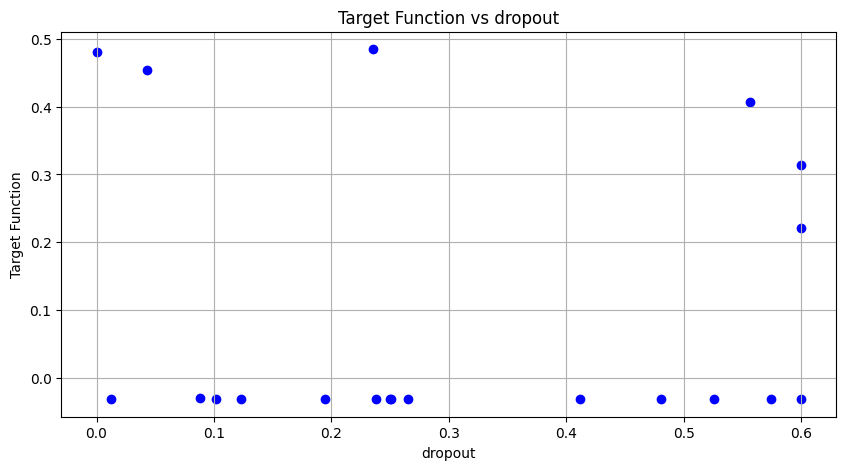

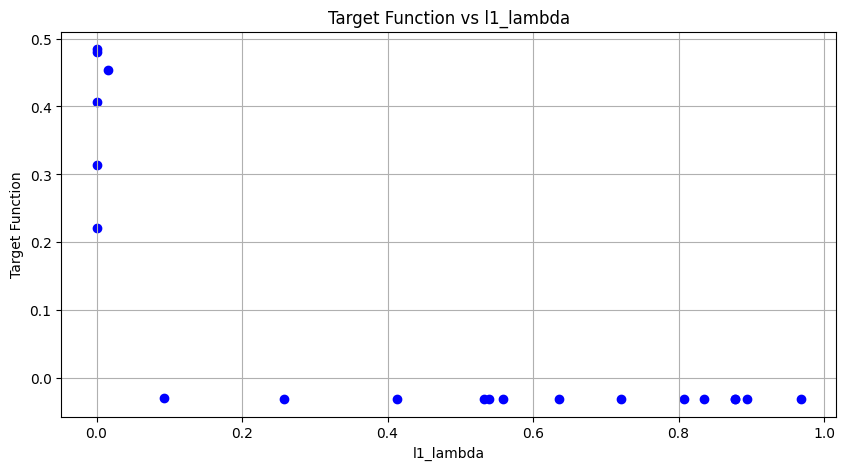

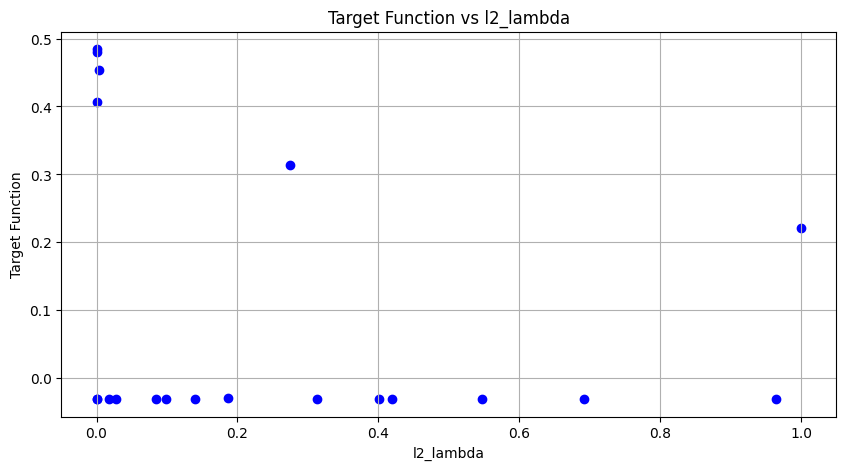

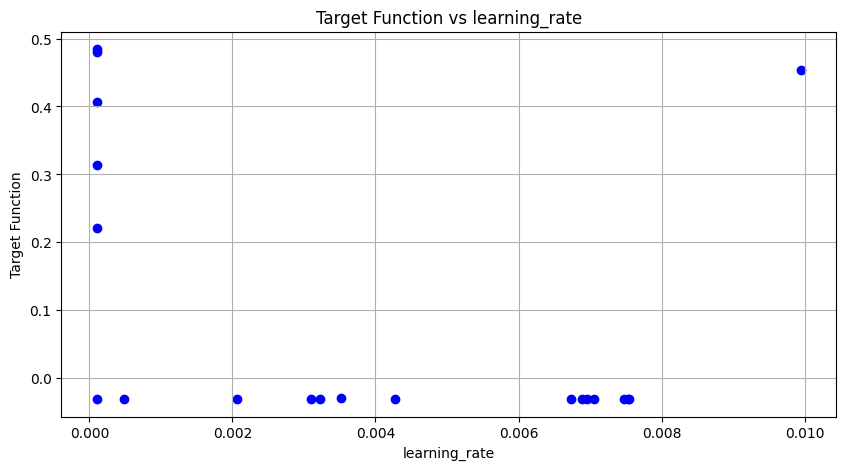

In [11]:


# def plot_parameter_trials(optimizer, saving_folder):
#     with open(saving_folder + '/best_hyperparams.txt', 'w') as file:
#         file.write(str(optimizer.max))
#     # Extracting results
#     results = optimizer.res  # This gives you a list of dictionaries

#     # Preparing data for plotting
#     param_names = list(results[0]['params'].keys())  # Get parameter names
#     data = {name: [] for name in param_names}
#     target = []

#     for res in results:
#         for name in param_names:
#             data[name].append(res['params'][name])
#         target.append(res['target'])

#     # Plotting
#     for name in param_names:
#         plt.figure(figsize=(10, 5))
#         plt.scatter(data[name], target, c='blue', marker='o')
#         plt.title(f'Target Function vs {name}')
#         plt.xlabel(name)
#         plt.ylabel('Target Function')
#         plt.grid(True)
#         plt.savefig(saving_folder + f'/{name}.png')
        # plt.close()
        # plt.show()
